<a href="https://colab.research.google.com/github/taraliu23/Urban-Data-Science/blob/main/GSV_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Urban Data Science

## Topic: 🚌🚶‍♀️Google Street View (GSV) and Computer Vision 🖥️ 👀

### Quantifying and Mapping Atlanta MARTA Stops' Popularity

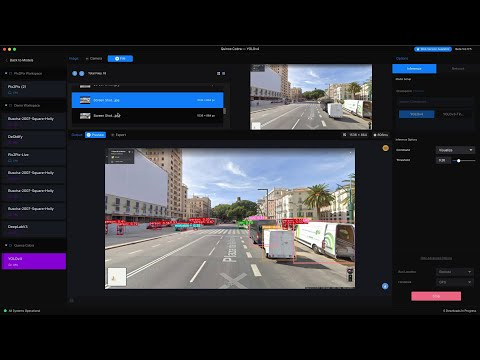

In [2]:
# let's get started!
# <- click on the buttom to run this cell

from IPython.display import YouTubeVideo
from IPython.display import Image

YouTubeVideo('QYbEDOrgPu0',allow_autoplay=True, width=600)

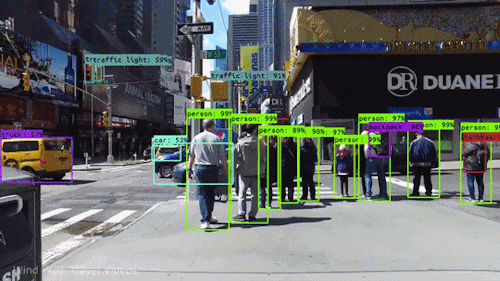

In [ ]:
Image('/content/yolo5.gif', width=400)

## Resources:

1. Computer Vision model selection: https://universe.roboflow.com/search?q=class:sidewalk

2. Using deep learning and Google Street View to estimate the demographic makeup of neighborhoods across the United States https://www.pnas.org/doi/10.1073/pnas.1700035114

### Project Overview

This project uses Google Street View (GSV) images and image segementation methods to analyze greenery and walkability in Midtown Atlanta.

The results provide actionable insights for urban green space and sidewalk planning.

### Objectives


Popularity Analysis: Estimate popularity scores based on street-level features (e.g., people amount).

Data Visualization: Map findings in spatial distribution of popularity of stations, linking to demographic features.

### Tools and Technologies
Language: Python

Libraries:
- google-streetview: Download GSV images.
- ultralytics: Computer Vision Model.
- pandas: Wrangle and orginize data.
- matplotlib: Create scatterplots.
- folium: Visualize spatial data.

Environment: Jupyter Notebook with Google Colab

Other Requirements: Google API Key

### Deliverables
1. Interactive Map: Spatial distribution of popularity in MARTA stops Atlanta.
2. Key Visualizations: Scatterplot of greenery vs. walkability. Heatmap of greenery scores.
3. Summary Document: One-page brief summarizing results and insights.


## Step 1: Set Up

1. (Optional) Change runtime to GPU/TPU for faster computing.

    Steps:
    Top right corner "Runtime" -> Change runtime type -> Hardware accelerator -> T4 GPU -> Save



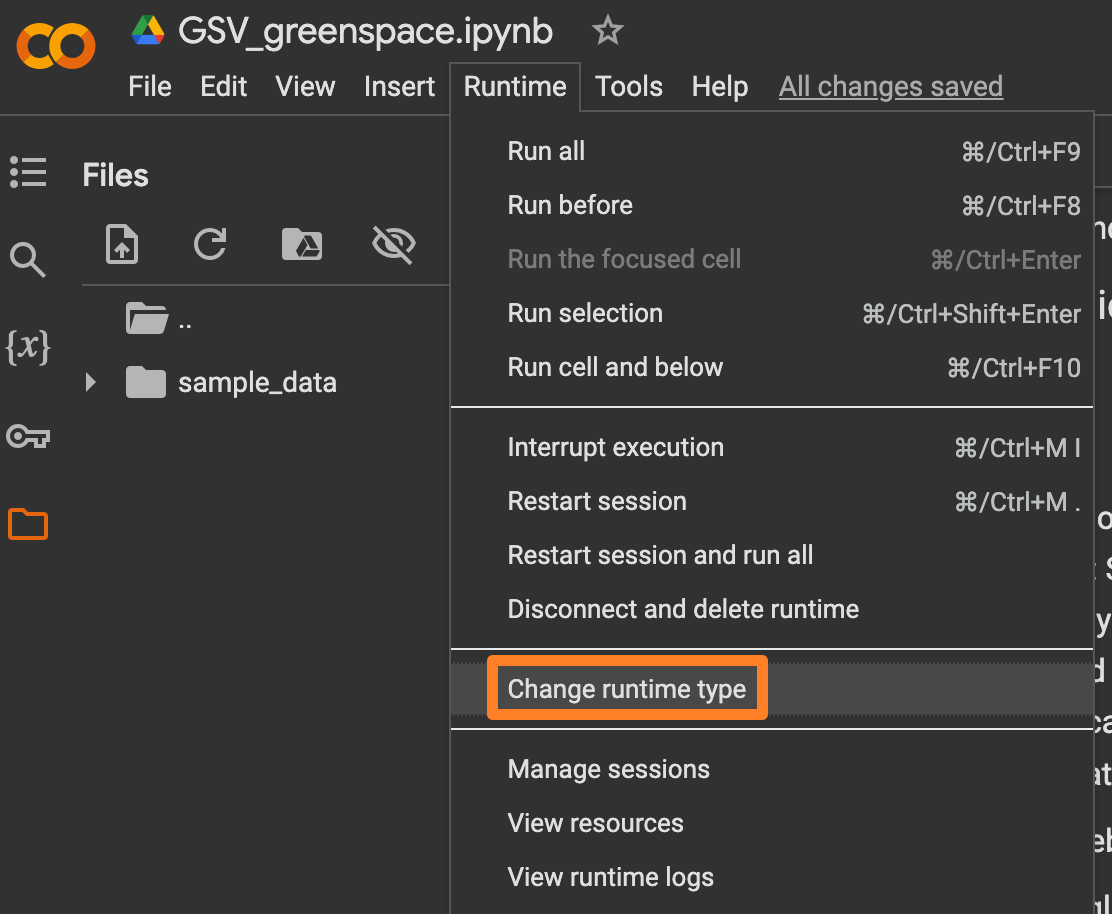

In [ ]:
Image('/content/step1_1.jpg', width=400)

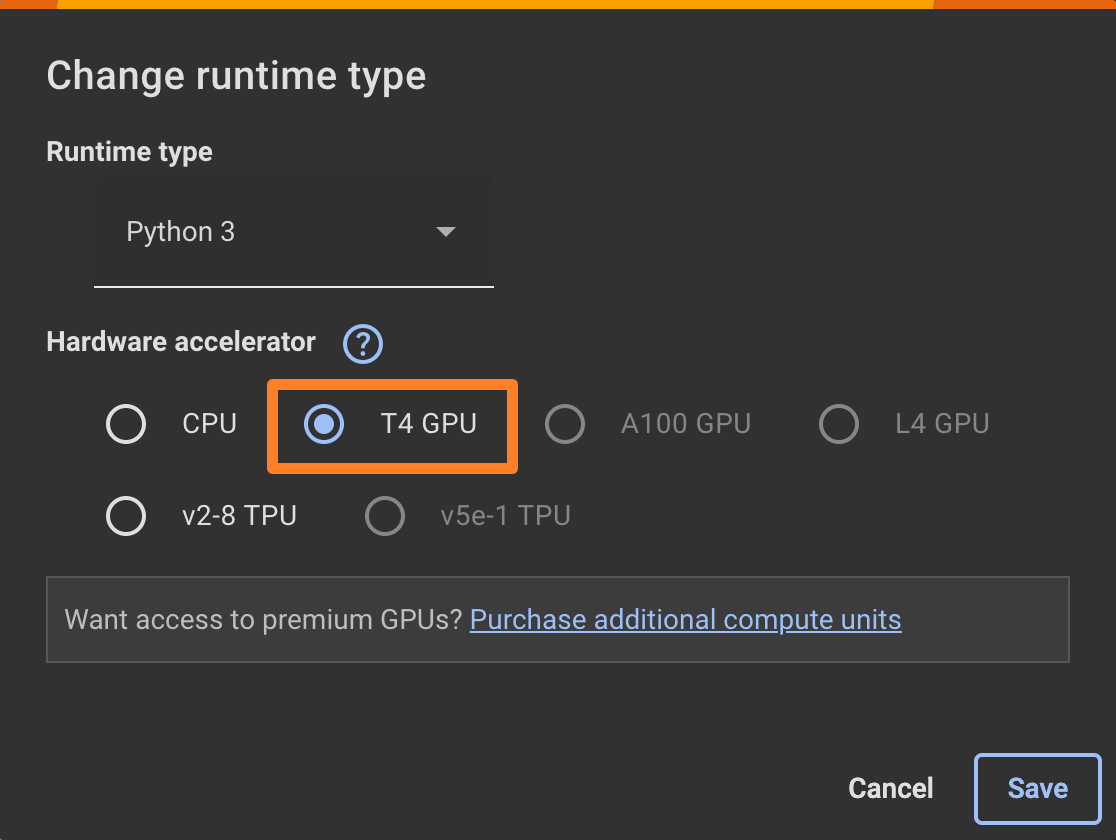

In [ ]:
Image('/content/step1_2.jpg', width=400)

In [ ]:
# monitor current hardware accelerator
! nvidia-smi

Mon Jan  6 20:53:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |    595MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2. Install Required Libraries

In [ ]:
! pip --quiet install \
google_streetview \
opencv-python \
keras-segmentation \
pandas \
geopandas \
numpy \
matplotlib \
folium \
tqdm \
ultralytics

3. Set API key

Steps: Set up a Google Cloud project -> Create an API Key for static street view download

(You don't need to mannually create project/ API Keys, just run cells below)

**Remember: 🤫 Do not share your API Key and credentials to anyone! 🤫**


In [ ]:
# use google cloud sdk to login in google account

! gcloud auth login --no-launch-browser --quiet
# follow the cell output, click on the auth link, copy the verficication code, and paste in the blinking cursor.

In [ ]:
! gcloud projects create "urban-data-science-gsv"

In [ ]:
! gcloud alpha services api-keys create \
    --project "urban-data-science-gsv" \
    --display-name "Street_View_Static_API_Key"\

In [ ]:
! gcloud services api-keys list --project="urban-data-science-gsv"

## Step 2: Download Google Street View Images

In [ ]:
# import all necessary packages！
import google_streetview.api

from google.colab import userdata

import os
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import torch
import json

from PIL import Image
from ultralytics import YOLO
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tqdm import tqdm
from tqdm.notebook import trange, tqdm

In [ ]:
def download_gsv_images(locations_df, api_key):
    """
    Downloads Google Street View images based on coordinates from a dataframe.

    Args:
        locations_df (pd.DataFrame): A Pandas DataFrame with a 'latitude' and 'longitude' column.
        api_key (str): Your Google Street View Static API key.
    """

    # os.makedirs("gsv_images", exist_ok=True)
    os.makedirs("/content/drive/MyDrive/gsv_images", exist_ok=True)

    for index, row in locations_df.iterrows():
        latitude = row['latitude']
        longitude = row['longitude']
        location = f"{latitude},{longitude}"
        params = [{
            "size": "640x640",
            "location": location,
            "heading": "0", # could also be 90, 270, 360
            "pitch": "0",
            "key": api_key
        }]
        try:
            results = google_streetview.api.results(params)
            results.download_links(f"gsv_images/image_{index}")
            print(f"Downloaded image for location: {location}")
        except Exception as e:
            print(f"Error downloading image for {location}: {e}")



In [ ]:
def read_marta_stops_geojson(filepath):
    """Reads a GeoJSON file containing MARTA stop locations and returns a DataFrame with coordinates.

    Args:
        filepath (str): The path to the GeoJSON file.

    Returns:
        geopandas.GeoDataFrame: A GeoDataFrame containing the location data of MARTA stops.
                                Returns None if the file is not found or an error occurs.
    """
    try:
        gdf = gpd.read_file(filepath)
        # Rename columns
        gdf = gdf.rename(columns={"stop_lat": "latitude", "stop_lon": "longitude"})
        return gdf

    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [ ]:
gdf = read_marta_stops_geojson('/content/MARTA_Stops.geojson')

In [ ]:
# download gsv dataset
download_gsv_images(gdf[['latitude','longitude']], userdata.get('Street_View_Static_API_Key'))

Downloaded image for location: 33.754553,-84.469302
Downloaded image for location: 33.753328,-84.445329
Downloaded image for location: 33.753247,-84.445568
Downloaded image for location: 33.754517,-84.469824
Downloaded image for location: 33.920862,-84.344213
Downloaded image for location: 33.823385,-84.369357
Downloaded image for location: 33.823492,-84.369324
Downloaded image for location: 33.92113,-84.344268
Downloaded image for location: 33.860329,-84.339245
Downloaded image for location: 33.859989,-84.339397
Downloaded image for location: 33.789669,-84.387414
Downloaded image for location: 33.788828,-84.387272
Downloaded image for location: 33.781247,-84.386342
Downloaded image for location: 33.781355,-84.386353
Downloaded image for location: 33.765241,-84.312937
Downloaded image for location: 33.765196,-84.313426
Downloaded image for location: 33.774699,-84.295417
Downloaded image for location: 33.761803,-84.340825
Downloaded image for location: 33.750161,-84.385915
Downloaded im

KeyboardInterrupt: 

In [ ]:

!zip -r /content/gsv_images.zip /content/gsv_images




## Step 3: Popularity Analysis with Instance Segmentation Model YOLO v8



In [ ]:
import cv2
import torch
from PIL import Image

import pandas as pd
import json
from ultralytics import YOLO
import os

In [ ]:
# if you use pre-downloaded dataset:
# drag gsv_images.zip to the left panel - Files
# unzip files

!unzip /content/gsv_images.zip -d /content/gsv_images


Archive:  /content/gsv_images.zip
replace /content/gsv_images/content/gsv_images/image_205/metadata.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/gsv_images/content/gsv_images/image_205/metadata.json  
replace /content/gsv_images/content/gsv_images/image_205/gsv_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace /content/gsv_images/content/gsv_images/image_205/gsv_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:

def analyze_image(image_path, model):
    """
    Performs instance segmentation on a given image using YOLOv8.

    Args:
        image_path (str): Path to the image file.
        model (YOLO): The loaded YOLOv8 model.

    Returns:
        pandas.DataFrame: A DataFrame containing inference results, including location, label, and metadata.
                         Returns None if the image file or metadata file is not found.
    """
    try:
        # Perform inference
        results = model.predict(source=image_path, save=True, imgsz=640, conf=0.5)

        # Extract metadata from the metadata.json file in the same directory
        metadata_file = os.path.join(os.path.dirname(image_path), "metadata.json")
        with open(metadata_file, "r") as f:
            metadata = json.load(f)

        # Create an empty list to store inference data
        inference_data = []

        # Iterate through each detection
        for result in results:
            boxes = result.boxes
            for box in boxes:
                label = result.names[int(box.cls)]
                confidence = box.conf.item()
                x1, y1, x2, y2 = box.xyxy[0].tolist()

                inference_data.append({
                    # "location": metadata.get("location"), # Get location from metadata
                    "label": label,
                    "confidence": confidence,
                    "x1": x1,
                    "y1": y1,
                    "x2": x2,
                    "y2": y2,
                    "metadata": metadata  # Include the entire metadata
                })

        # Create DataFrame
        df = pd.DataFrame(inference_data)
        return df

    except FileNotFoundError:
        print(f"Error: Image or metadata file not found at {image_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None



In [ ]:
model = YOLO('yolov8n-seg.pt')

In [ ]:
path = '/content/gsv_images/content/gsv_images/image_1/gsv_0.jpg'
df = analyze_image(path,model)


image 1/1 /content/gsv_images/content/gsv_images/image_1/gsv_0.jpg: 640x640 1 car, 12.1ms
Speed: 2.0ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict4


In [ ]:

def process_subfolders(root_dir, num_folders=10):
  """
  Processes the first 'num_folders' subfolders within 'root_dir'.

  Args:
      root_dir: The root directory containing the subfolders.
      num_folders: The number of subfolders to process.

  Returns:
      A pandas DataFrame containing data from processed subfolders,
      or None if an error occurs.
  """

  all_data = []
  subfolders = [f.path for f in os.scandir(root_dir) if f.is_dir()]

  for i, folder in enumerate(subfolders[:num_folders]):
      try:

          for filename in os.listdir(folder):
              if filename.endswith('.jpg'):
                image_path = os.path.join(folder, filename)
                # Placeholder data for demonstration
                all_data.append({
                    'subfolder': os.path.basename(folder),
                    'image_file': filename,
                    'image_path': image_path
                })
      except Exception as e:
          print(f"Error processing subfolder {folder}: {e}")
  return pd.DataFrame(all_data)


In [ ]:
root_directory = '/content/gsv_images/content/gsv_images'
final_df = process_subfolders(root_directory, num_folders=60)

if final_df is not None:
    final_df

In [ ]:
results.to_csv('results.csv', index=False)

In [ ]:
results

label  confidence          x1          y1          x2  \
0               car    0.932570  126.625946  335.024048  289.579193   
1               car    0.685419  266.512695  328.511292  320.713074   
2               car    0.801924  575.717834  332.515045  617.984070   
3               car    0.752523  337.927032  320.009064  361.200714   
4               car    0.669446  172.885468  330.759216  243.435150   
...             ...         ...         ...         ...         ...   
2094  traffic light    0.830764  331.764435  213.644470  345.207123   
2095  traffic light    0.784800   26.176939  244.732559   44.263550   
2096            car    0.523273  145.463104  333.932800  177.010742   
2097            car    0.931818  134.814423  350.191589  382.993866   
2098            car    0.789256  546.851074  318.680115  575.010742   

              y2                                           metadata  
0     421.219238  [{'copyright': '© Google', 'date': '2021-12', ...  
1     362.298035  [{'copyright': '© Google', 'date': '2021-12', ...  
2     355.878448  [{'copyright': '© Google', 'date': '2024-12', ...  
3     331.479156  [{'copyright': '© Google', 'date': '2024-12', ...  
4     374.897034  [{'copyright': '© Google', 'date': '2024-12', ...  
...          ...                                                ...  
2094  244.266846  [{'copyright': '© Google', 'date': '2022-02', ...  
2095  270.687012  [{'copyright': '© Google', 'date': '2022-02', ...  
2096  356.019531  [{'copyright': '© Google', 'date': '2022-02', ...  
2097  520.752869  [{'copyright': '© Google', 'date': '2024-07', ...  
2098  338.156799  [{'copyright': '© Google', 'date': '2024-07', ...  

[2099 rows x 7 columns]

In [ ]:
# results = pd.read_csv('/content/results.csv')

results


label  confidence          x1          y1          x2  \
0               car    0.932570  126.625946  335.024048  289.579193   
1               car    0.685419  266.512695  328.511292  320.713074   
2               car    0.801924  575.717834  332.515045  617.984070   
3               car    0.752523  337.927032  320.009064  361.200714   
4               car    0.669446  172.885468  330.759216  243.435150   
...             ...         ...         ...         ...         ...   
2094  traffic light    0.830764  331.764435  213.644470  345.207123   
2095  traffic light    0.784800   26.176939  244.732559   44.263550   
2096            car    0.523273  145.463104  333.932800  177.010742   
2097            car    0.931818  134.814423  350.191589  382.993866   
2098            car    0.789256  546.851074  318.680115  575.010742   

              y2                                           metadata  
0     421.219238  [{'copyright': '© Google', 'date': '2021-12', ...  
1     362.298035  [{'copyright': '© Google', 'date': '2021-12', ...  
2     355.878448  [{'copyright': '© Google', 'date': '2024-12', ...  
3     331.479156  [{'copyright': '© Google', 'date': '2024-12', ...  
4     374.897034  [{'copyright': '© Google', 'date': '2024-12', ...  
...          ...                                                ...  
2094  244.266846  [{'copyright': '© Google', 'date': '2022-02', ...  
2095  270.687012  [{'copyright': '© Google', 'date': '2022-02', ...  
2096  356.019531  [{'copyright': '© Google', 'date': '2022-02', ...  
2097  520.752869  [{'copyright': '© Google', 'date': '2024-07', ...  
2098  338.156799  [{'copyright': '© Google', 'date': '2024-07', ...  

[2099 rows x 7 columns]

In [ ]:
# extract street image date and location from metadata column

df['metadata'] = df['metadata'].apply(lambda x: x[0])
df['date'] = df['metadata'].apply(lambda x: x.get('date'))
df['lat'] = df['metadata'].apply(lambda x: x.get('location').get('lat'))
df['lon'] = df['metadata'].apply(lambda x: x.get('location').get('lng'))

In [ ]:
df

df.to_csv('results_new.csv', index=False)

## Step 6: Map spatial distribution of Popularity

## Crash Course: Deep Learning, Computer Vision, and their applications in urban data science



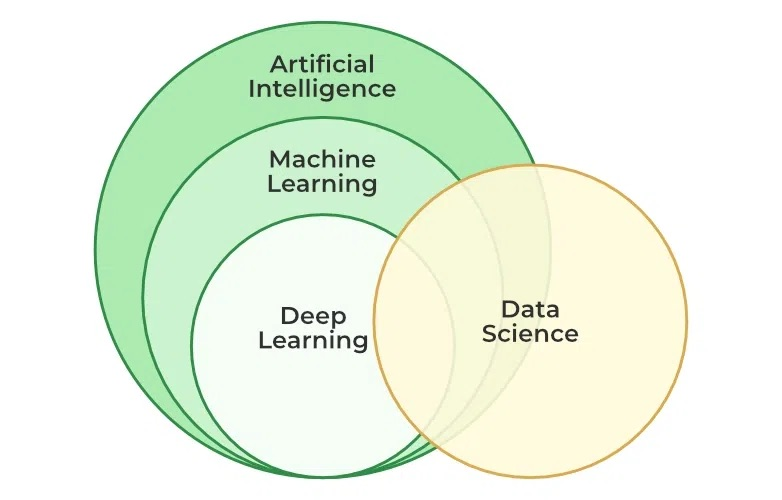

In [3]:
Image('/content/Maachine-Learning.jpeg', width=400)

# A Venn Diagram of Machine Learning and Deep Learning [6]

What is Deep Learning?

Deep learning is an artificial intelligence (AI) method that teaches computers to process data in a way **inspired by the human brain 🧠**.

Deep learning models can recognize complex pictures, text, sounds, and other data patterns to produce accurate insights and predictions.

You can use deep learning methods to automate tasks that typically require human intelligence, such as describing images or transcribing a sound file into text [5].

[[Read the Deep Learning Book]](https://www.deeplearningbook.org/)



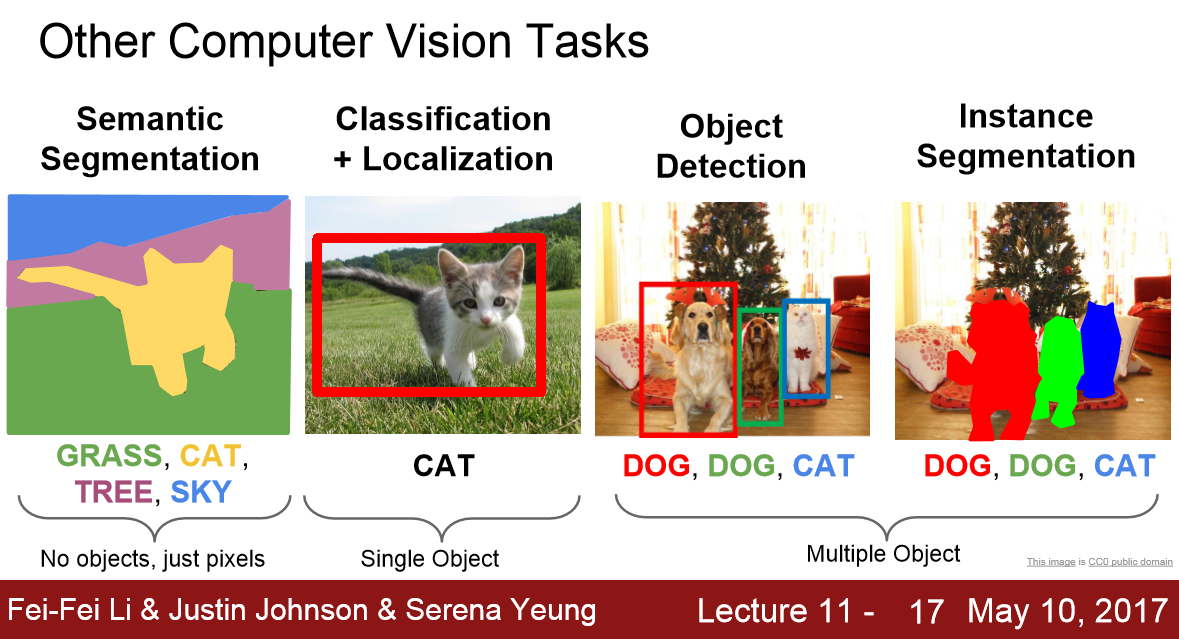

In [6]:
Image('/content/computer-vision-task.png', width=400)
# Coputer Vision Tasks [3]

**Key Concepts in Computer Vision**

- Image Classification: Assigning a label to an entire image.

- Object Detection: Identifying and localizing objects within an image.

- Semantic Segmentation: Assigning a label to every pixel in an image.

- Instance Segmentation: Combining object detection and semantic segmentation.

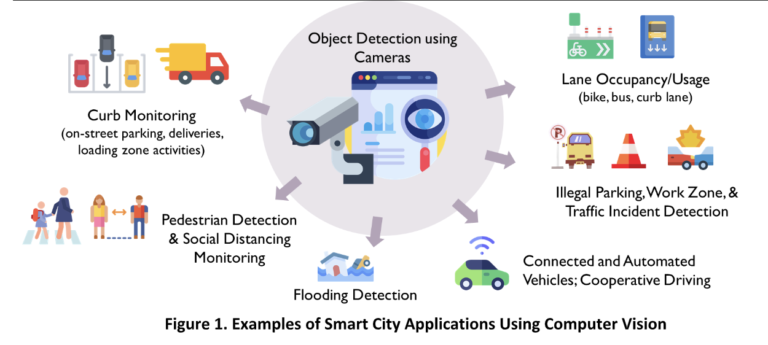

In [ ]:
Image('/content/computer-vision-graphic-768x345.png')

Fun fact about GSV:

- Google attempts to take fresh Street View images in major cities once a year. In less populated areas, new images should be expected every three years.

- The new cars are all Hyundai Elantra GTs. The cars mostly end up being blue and brown, which is a lot more subtle than the old Google Maps-themed Street View cars and their big green doors[4].

[[Learn More about How GSV works!]](https://www.google.com/streetview/how-it-works/)

## Reference

  
[1] I. Mihajlovic, “Everything You Ever Wanted To Know About Computer Vision.,” Towards Data Science, Dec. 13, 2024. Accessed: Jan. 01, 2025. [Online]. Available: https://towardsdatascience.com/everything-you-ever-wanted-to-know-about-computer-vision-heres-a-look-why-it-s-so-awesome-e8a58dfb641e


[2] “Exploring Cost-effective Computer Vision Solutions for Smart Transportation Systems - C2SMARTER Home,” C2SMARTER Home - Connected Cities for Smart Mobility toward Accessible and Resilient Transportation. Accessed: Jan. 01, 2025. [Online]. Available: https://c2smarter.engineering.nyu.edu/exploring-cost-effective-computer-vision-solutions-for-smart-transportation-systems/
  
[3] “Stanford University CS231n: Deep Learning for Computer Vision.” Accessed: Jan. 01, 2025. [Online]. Available: https://cs231n.stanford.edu/index.html
  
[4] R. Amadeo, “Google’s Street View cars are now giant, mobile 3D scanners,” Ars Technica, Sep. 06, 2017. Accessed: Jan. 07, 2025. [Online]. Available: https://arstechnica.com/gadgets/2017/09/googles-street-view-cars-are-now-giant-mobile-3d-scanners/
  
[5]  “What is Deep Learning? - Deep Learning AI Explained - AWS,” Amazon Web Services, Inc. Accessed: Jan. 07, 2025. [Online]. Available: https://aws.amazon.com/what-is/deep-learning/

[6] GeeksforGeeks, “Introduction to Deep Learning,” GeeksforGeeks, Jun. 01, 2018. Accessed: Jan. 07, 2025. [Online]. Available: https://www.geeksforgeeks.org/introduction-deep-learning/
  




todo:

- different marta station popularity -

- avalible gsv for each station: how many are downloadable, time span, dataset size

- crash course put to top



**bold text**## Hackthon

### Datasets

[cityspace](https://www.cityscapes-dataset.com/)

[Microsoft CoCo](https://cocodataset.org/#home)

### Models

[Try YoLo v5](https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb#scrollTo=wbvMlHd_QwMG)

[Try YoLo v8](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb#scrollTo=FDbMt_M6PiXb)

